In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
#merging all the required datasets - metabolomics dataset, drug response dataset and the metadata of the cell lines

data = pd.read_excel("D:\\GaTech\\Fall Sem\\BIOL 8901\\Metabolomic Project\\metabolomic_data.xlsx", sheet_name="1-clean data")
data.rename(columns = {'Unnamed: 0': 'ID'}, inplace = True)
last_column = data.iloc[:,-1].name
sample = pd.read_csv("D:\\GaTech\\Fall Sem\\BIOL 8901\\sample_info.csv")
sample.rename(columns = {'CCLE_Name':'ID'}, inplace=True)
merged_data = data.merge(sample, on='ID')
drug = pd.read_csv('D:\\GaTech\\Fall Sem\\BIOL 8901\\sanger-dose-response.csv')
drug.rename(columns={'ARXSPAN_ID':'DepMap_ID'}, inplace = True)
working_data = merged_data.merge(drug, on='DepMap_ID')

In [4]:
working_data.head(10)

,ID,2-aminoadipate,3-phosphoglycerate,alpha-glycerophosphate,4-pyridoxate,aconitate,adenine,adipate,alpha-ketoglutarate,AMP,...,DRUG_NAME,BROAD_ID,upper_limit,ec50,slope,lower_limit,auc,log2.ic50,mse,R2
0,DMS53_LUNG,6.112727,6.034198,5.896896,6.000532,5.513618,5.868529,5.977177,5.693074,5.923737,...,DOXORUBICIN,"BRD-K92093830, BRD-A52530684, BRD-K61468417",0.932547,6.533872e-01,-8.901463,0.535007,0.900190,NaN,1.151287e-03,0.927925
1,DMS53_LUNG,6.112727,6.034198,5.896896,6.000532,5.513618,5.868529,5.977177,5.693074,5.923737,...,ETOPOSIDE,"BRD-K37798499, BRD-A33280134, BRD-K36186323, B...",0.998083,2.400159e+00,-1.880861,0.882042,0.958086,NaN,7.486886e-04,0.724984
2,DMS53_LUNG,6.112727,6.034198,5.896896,6.000532,5.513618,5.868529,5.977177,5.693074,5.923737,...,GEMCITABINE,"BRD-K15108141, BRD-K67681739, BRD-K11238904",0.971751,1.957485e-01,-1.961257,0.617560,0.864834,NaN,1.675194e-03,0.911867
3,DMS53_LUNG,6.112727,6.034198,5.896896,6.000532,5.513618,5.868529,5.977177,5.693074,5.923737,...,MITOMYCIN-C,BRD-A48237631,1.089647,7.876277e-01,-0.899952,0.001208,0.505752,-0.076157,4.204267e-03,0.962517
4,DMS53_LUNG,6.112727,6.034198,5.896896,6.000532,5.513618,5.868529,5.977177,5.693074,5.923737,...,VINORELBINE,"BRD-K04269837, BRD-K69280563",0.988597,2.000661e-02,-0.608512,0.840494,0.942902,NaN,2.875568e-04,0.760183
5,DMS53_LUNG,6.112727,6.034198,5.896896,6.000532,5.513618,5.868529,5.977177,5.693074,5.923737,...,NSC-87877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,DMS53_LUNG,6.112727,6.034198,5.896896,6.000532,5.513618,5.868529,5.977177,5.693074,5.923737,...,BICALUTAMIDE,BRD-A29485665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,DMS53_LUNG,6.112727,6.034198,5.896896,6.000532,5.513618,5.868529,5.977177,5.693074,5.923737,...,QS11,NaN,0.985203,5.302192e+22,-0.379964,-3023.976657,0.985196,NaN,3.140087e-04,-0.000084
8,DMS53_LUNG,6.112727,6.034198,5.896896,6.000532,5.513618,5.868529,5.977177,5.693074,5.923737,...,CP466722,NaN,1.000144,2.085594e+01,-6.728454,0.247023,0.996894,NaN,1.378624e-07,0.999881
9,DMS53_LUNG,6.112727,6.034198,5.896896,6.000532,5.513618,5.868529,5.977177,5.693074,5.923737,...,MIDOSTAURIN,BRD-K13646352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
X1 = working_data[(working_data['DRUG_NAME'] == 'CISPLATIN') & (working_data['lineage'] == 'lung') & (working_data['DATASET'] != 'GDSC1')]
X1.head(2)

,ID,2-aminoadipate,3-phosphoglycerate,alpha-glycerophosphate,4-pyridoxate,aconitate,adenine,adipate,alpha-ketoglutarate,AMP,...,DRUG_NAME,BROAD_ID,upper_limit,ec50,slope,lower_limit,auc,log2.ic50,mse,R2
280,DMS53_LUNG,6.112727,6.034198,5.896896,6.000532,5.513618,5.868529,5.977177,5.693074,5.923737,...,CISPLATIN,"BRD-K69172251, BRD-K33494261, BRD-K01228321",0.985746,2.274467,-1.966950,0.821795,0.962421,NaN,0.000613,0.78342
1147,NCIH1694_LUNG,5.886398,5.574881,5.541259,5.848375,5.665026,5.875548,5.894904,5.839640,5.742613,...,CISPLATIN,"BRD-K69172251, BRD-K33494261, BRD-K01228321",0.934955,1.951074,-1.668638,0.552481,0.868015,NaN,0.001241,0.92007


In [6]:
X1.shape

(109, 270)

In [7]:
X1.reset_index(inplace=True, drop=True)
X1.head(2)

,ID,2-aminoadipate,3-phosphoglycerate,alpha-glycerophosphate,4-pyridoxate,aconitate,adenine,adipate,alpha-ketoglutarate,AMP,...,DRUG_NAME,BROAD_ID,upper_limit,ec50,slope,lower_limit,auc,log2.ic50,mse,R2
0,DMS53_LUNG,6.112727,6.034198,5.896896,6.000532,5.513618,5.868529,5.977177,5.693074,5.923737,...,CISPLATIN,"BRD-K69172251, BRD-K33494261, BRD-K01228321",0.985746,2.274467,-1.966950,0.821795,0.962421,NaN,0.000613,0.78342
1,NCIH1694_LUNG,5.886398,5.574881,5.541259,5.848375,5.665026,5.875548,5.894904,5.839640,5.742613,...,CISPLATIN,"BRD-K69172251, BRD-K33494261, BRD-K01228321",0.934955,1.951074,-1.668638,0.552481,0.868015,NaN,0.001241,0.92007


In [8]:
X_meta = X1[data.columns]
X_meta.drop(columns = 'ID', inplace=True)
X_meta.head(2)

,2-aminoadipate,3-phosphoglycerate,alpha-glycerophosphate,4-pyridoxate,aconitate,adenine,adipate,alpha-ketoglutarate,AMP,citrate,...,C56:8 TAG,C56:7 TAG,C56:6 TAG,C56:5 TAG,C56:4 TAG,C56:3 TAG,C56:2 TAG,C58:8 TAG,C58:7 TAG,C58:6 TAG
0,6.112727,6.034198,5.896896,6.000532,5.513618,5.868529,5.977177,5.693074,5.923737,5.641242,...,6.070239,6.133433,6.091089,6.257711,6.372732,6.202511,5.939576,6.309821,6.115974,5.999436
1,5.886398,5.574881,5.541259,5.848375,5.665026,5.875548,5.894904,5.839640,5.742613,5.570208,...,5.942887,5.946988,5.837980,5.913350,6.137530,5.807546,5.704149,5.881193,5.785208,5.504225


In [9]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X_meta), columns = X_meta.columns)
X.head(2)

,2-aminoadipate,3-phosphoglycerate,alpha-glycerophosphate,4-pyridoxate,aconitate,adenine,adipate,alpha-ketoglutarate,AMP,citrate,...,C56:8 TAG,C56:7 TAG,C56:6 TAG,C56:5 TAG,C56:4 TAG,C56:3 TAG,C56:2 TAG,C58:8 TAG,C58:7 TAG,C58:6 TAG
0,0.518028,0.546984,0.506365,0.590050,0.193808,0.439797,0.581755,0.365174,0.289218,0.263066,...,0.493031,0.604575,0.644839,0.716317,0.731688,0.698283,0.457498,0.734339,0.673020,0.504866
1,0.405670,0.162783,0.354900,0.476725,0.321570,0.443981,0.483184,0.485102,0.195147,0.208856,...,0.399137,0.482789,0.455334,0.493013,0.595671,0.486072,0.330999,0.506692,0.526081,0.255140


In [10]:
labels, ic = [], list(X1.IC50_PUBLISHED)

In [11]:
for i in range(len(ic)):
    #if the IC50_PUBLISHED value is greater than the mean, add responsive label to the label list
    if ic[i] > 8.00:
        labels.append('NR')
    #if the IC50_PUBLISHED value is less than the mean, add non responsive label to the label list
    elif ic[i] < 8.00 and ic[i] > 0.004:
        labels.append('R')
y = pd.Series(labels)
X.shape, y.shape

((109, 225), (109,))

In [12]:
y.value_counts()

NR    91
R     18
dtype: int64

In [13]:
rfecv = RFECV(estimator = SVC(kernel='linear'), step=1, scoring='accuracy', cv=StratifiedKFold(3))
rfecv.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
      estimator=SVC(kernel='linear'), scoring='accuracy')

In [14]:
rfecv.n_features_

36

In [ ]:
#X = X[X.columns[features]]

In [ ]:
#X.columns

In [15]:
n_splits = 5
kf = StratifiedKFold(n_splits = n_splits, random_state=101, shuffle=True)
rkf = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = 10)
model1 = SVC(kernel='linear', C=1)
model2 = RandomForestClassifier(random_state=101)
model3 = AdaBoostClassifier(base_estimator=RandomForestClassifier(random_state=101), n_estimators = 350, algorithm='SAMME', learning_rate=5.0)

In [31]:
acc_svm, acc_rf, acc_adb = [], [], []
f1_svm, f1_rf, f1_adb = [], [], []
feature_list_rfecv, feature_list_rfe = [], []
cf_matrix_svm, cf_matrix_rf, cf_matrix_adb = [[0, 0], [0, 0]], [[0, 0], [0, 0]], [[0, 0], [0, 0]]
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rfe = RFE(estimator=SVC(kernel='linear', C=1), step=1, n_features_to_select = rfecv.n_features_)
    rfe.fit(X_train, y_train)
    X_train_rfe = X_train[X_train.columns[rfe.get_support(1)]]
    X_test_rfe = X_test[X_test.columns[rfe.get_support(1)]]
    #print(X_train_new.columns)
    #print(len(X_train_new.columns))
    feature_list_rfe.append(X_train_rfe.columns.values.tolist())
    model1.fit(X_train_rfe, y_train)
    model2.fit(X_train_rfe, y_train)
    model3.fit(X_train_rfe, y_train)
    y_pred1 = model1.predict(X_test_rfe)
    y_pred2 = model2.predict(X_test_rfe)
    y_pred3 = model3.predict(X_test_rfe)
    acc_svm.append(accuracy_score(y_test, y_pred1))
    acc_rf.append(accuracy_score(y_test, y_pred2))
    acc_adb.append(accuracy_score(y_test, y_pred3))
    f1_svm.append(f1_score(y_test, y_pred1, average='weighted', pos_label = 'R'))
    f1_rf.append(f1_score(y_test, y_pred2, average='weighted', pos_label = 'R'))
    f1_adb.append(f1_score(y_test, y_pred3, average='weighted', pos_label = 'R'))
    cf_matrix_svm += confusion_matrix(y_test, y_pred1)
    cf_matrix_rf += confusion_matrix(y_test, y_pred2)
    cf_matrix_adb += confusion_matrix(y_test, y_pred3)
cf_matrix_svm = cf_matrix_svm
cf_matrix_rf = cf_matrix_rf
cf_matrix_adb = cf_matrix_adb

In [34]:
from collections import Counter
print(feature_list_rfe)

[['3-phosphoglycerate', 'adenine', 'citrate', 'CMP', 'cystathionine', 'cytidine', 'DHAP/glyceraldehyde 3P', 'glutathione oxidized', 'NAD', 'oxalate', 'pantothenate', 'taurodeoxycholate/taurochenodeoxycholate', 'glutamine', 'tryptophan', 'ornithine', 'betaine', 'creatine', 'creatinine', 'cotinine', 'pipecolic acid', '1-methylnicotinamide', 'putrescine', 'acetylcarnitine', 'propionylcarnitine', 'lauroylcarnitine', 'C20:4 LPE', 'C22:6 LPE', 'C32:1 PC', 'C34:4 PC', 'C24:1 SM', 'C36:1 DAG', 'C22:6 CE', 'C50:0 TAG', 'C52:1 TAG', 'C54:1 TAG', 'C56:4 TAG'], ['aconitate', 'citrate', 'cystathionine', 'hexoses (HILIC neg)', 'NAD', 'NADP', 'glycodeoxycholate/glycochenodeoxycholate', 'phosphocreatine', '6-phosphogluconate', 'alpha-hydroxybutyrate', 'ornithine', 'homocysteine', '5-adenosylhomocysteine', 'alpha-glycerophosphocholine', 'trimethylamine-N-oxide', 'adenosine', '2-deoxycytidine', 'pipecolic acid', 'putrescine', 'lauroylcarnitine', 'palmitoylcarnitine', 'C20:4 LPE', 'C32:1 PC', 'C36:4 PC-A

In [36]:
featureCounts = []
for x in feature_list_rfe:
    for y in x:
        featureCounts.append(y)
print(featureCounts)

['3-phosphoglycerate', 'adenine', 'citrate', 'CMP', 'cystathionine', 'cytidine', 'DHAP/glyceraldehyde 3P', 'glutathione oxidized', 'NAD', 'oxalate', 'pantothenate', 'taurodeoxycholate/taurochenodeoxycholate', 'glutamine', 'tryptophan', 'ornithine', 'betaine', 'creatine', 'creatinine', 'cotinine', 'pipecolic acid', '1-methylnicotinamide', 'putrescine', 'acetylcarnitine', 'propionylcarnitine', 'lauroylcarnitine', 'C20:4 LPE', 'C22:6 LPE', 'C32:1 PC', 'C34:4 PC', 'C24:1 SM', 'C36:1 DAG', 'C22:6 CE', 'C50:0 TAG', 'C52:1 TAG', 'C54:1 TAG', 'C56:4 TAG', 'aconitate', 'citrate', 'cystathionine', 'hexoses (HILIC neg)', 'NAD', 'NADP', 'glycodeoxycholate/glycochenodeoxycholate', 'phosphocreatine', '6-phosphogluconate', 'alpha-hydroxybutyrate', 'ornithine', 'homocysteine', '5-adenosylhomocysteine', 'alpha-glycerophosphocholine', 'trimethylamine-N-oxide', 'adenosine', '2-deoxycytidine', 'pipecolic acid', 'putrescine', 'lauroylcarnitine', 'palmitoylcarnitine', 'C20:4 LPE', 'C32:1 PC', 'C36:4 PC-A', 

In [38]:
len(featureCounts)

180

In [37]:
from collections import Counter
print(Counter(featureCounts))

Counter({'cystathionine': 5, 'pipecolic acid': 5, 'C20:4 LPE': 5, 'C32:1 PC': 5, 'citrate': 4, 'pantothenate': 4, 'taurodeoxycholate/taurochenodeoxycholate': 4, 'homocysteine': 4, '2-deoxycytidine': 4, 'adenine': 3, 'glutathione oxidized': 3, 'tryptophan': 3, 'ornithine': 3, 'betaine': 3, 'creatinine': 3, 'cotinine': 3, 'putrescine': 3, 'lauroylcarnitine': 3, 'C22:6 LPE': 3, 'C24:1 SM': 3, 'C50:0 TAG': 3, 'C56:4 TAG': 3, 'aconitate': 3, '6-phosphogluconate': 3, 'trimethylamine-N-oxide': 3, 'C36:3 PC': 3, 'NAD': 2, 'creatine': 2, 'propionylcarnitine': 2, 'C36:1 DAG': 2, 'C22:6 CE': 2, 'C52:1 TAG': 2, 'C54:1 TAG': 2, 'hexoses (HILIC neg)': 2, 'NADP': 2, 'glycodeoxycholate/glycochenodeoxycholate': 2, 'phosphocreatine': 2, '5-adenosylhomocysteine': 2, 'alpha-glycerophosphocholine': 2, 'palmitoylcarnitine': 2, 'C34:2 DAG': 2, 'glutamate': 2, 'lactate': 2, 'anthranilic acid': 2, 'thymidine': 2, 'C18:2 SM': 2, '3-phosphoglycerate': 1, 'CMP': 1, 'cytidine': 1, 'DHAP/glyceraldehyde 3P': 1, 'oxa

In [17]:
print('Accuracy of SVM')
sum(acc_svm)/len(acc_svm)

Accuracy of SVM


0.789177489177489

In [18]:
print('Accuracy of RF')
sum(acc_rf)/len(acc_rf)

Accuracy of RF


0.8259740259740258

In [19]:
print('Accuracy of ADB')
sum(acc_adb)/len(acc_adb)

Accuracy of ADB


0.8168831168831169

In [20]:
print('F1 score for SVM')
sum(f1_svm)/len(f1_svm)

F1 score for SVM


0.7646237498869078

In [21]:
print('F1 score for RF')
sum(f1_rf)/len(f1_rf)

F1 score for RF


0.7667932153426376

In [22]:
print('F1 score for ADB')
sum(f1_adb)/len(f1_adb)

F1 score for ADB


0.7601734718807889

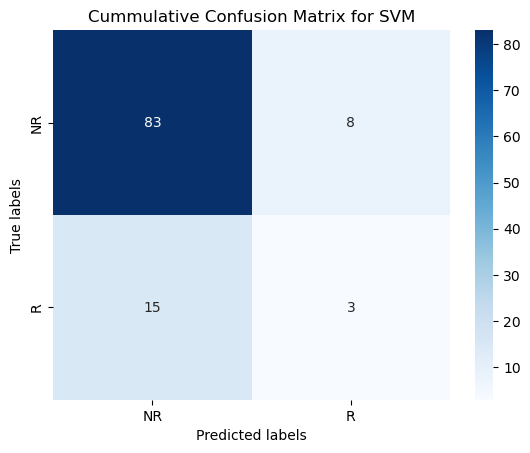

In [23]:
ax = sns.heatmap(cf_matrix_svm, annot=True, cmap='Blues')
ax.set_title('Cummulative Confusion Matrix for SVM')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['NR', 'R'])
ax.yaxis.set_ticklabels(['NR', 'R'])
plt.show()

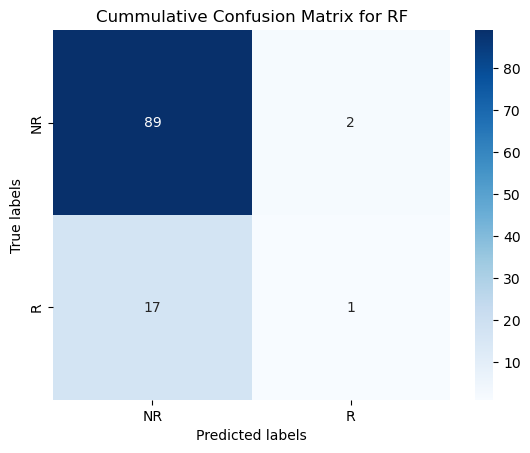

In [24]:
ax = sns.heatmap(cf_matrix_rf, annot=True, cmap='Blues')
ax.set_title('Cummulative Confusion Matrix for RF')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['NR', 'R'])
ax.yaxis.set_ticklabels(['NR', 'R'])
plt.show()

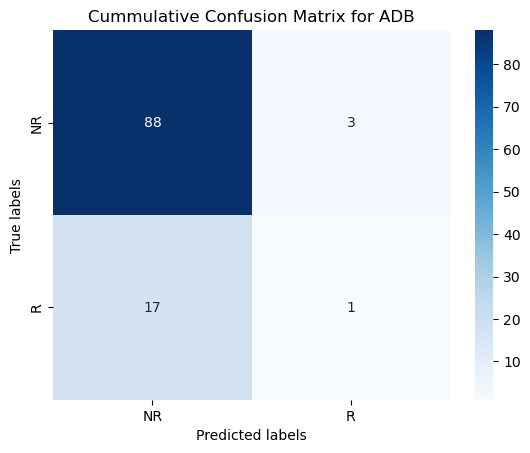

In [25]:
ax = sns.heatmap(cf_matrix_adb, annot=True, cmap='Blues')
ax.set_title('Cummulative Confusion Matrix for ADB')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['NR', 'R'])
ax.yaxis.set_ticklabels(['NR', 'R'])
plt.show()